# Predicting energy consumption

## Defining the Problem

Climate change is a globally relevant and urgent issue heavily impacted by energy policy and infrastructure.

According to a report issued by the International Energy Agency, the lifecycle of buildings from construction to demolition were responsible for 37% of global energy-related and process-related CO2 emissions in 2020.  Yet it is possible to drastically reduce the energy consumption of buildings by a combination of easy-to-implement fixes and state-of-the-art strategies. 

To do so, we need to analyze the differences in building energy consumption and create models to predict building energy consumption.  Accurate predictions of energy consumption can help policymakers target retrofitting efforts to maximize emissions reductions.


## Importing libraries we will need

In [168]:
import numpy as np # linear algebra
import pandas as pd # data processing
import time

#Data Visualization and Exploratory Data Analysis
import seaborn as sns 
import matplotlib.pyplot as plt

#Feature Engineering
from sklearn.preprocessing import MinMaxScaler

#Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Metrics
from sklearn.metrics import mean_squared_error
from math import sqrt

##  Loading the data

In [169]:
#Defining data and test paths

data_path= ('data/train.csv')
test_path= ('data/test.csv')

In [170]:
#Loading the data and test data in 2 different variables

data = pd.read_csv(data_path)
print("The shape of the data is:" + str(data.shape))

test_data = pd.read_csv(test_path)
print("The shape of the test data is:" + str(test_data.shape))

The shape of the data is:(75757, 64)
The shape of the test data is:(9705, 63)


In [171]:
#Let's look at the first rows of our train dataframe

data.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [172]:
#Let's take a look at our data features, its data types and an overview of the null values

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [173]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                9705 non-null   int64  
 1   State_Factor               9705 non-null   object 
 2   building_class             9705 non-null   object 
 3   facility_type              9705 non-null   object 
 4   floor_area                 9705 non-null   float64
 5   year_built                 9613 non-null   float64
 6   energy_star_rating         7451 non-null   float64
 7   ELEVATION                  9705 non-null   float64
 8   january_min_temp           9705 non-null   int64  
 9   january_avg_temp           9705 non-null   float64
 10  january_max_temp           9705 non-null   int64  
 11  february_min_temp          9705 non-null   int64  
 12  february_avg_temp          9705 non-null   float64
 13  february_max_temp          9705 non-null   int64

We can see that we have only 3 columns with object type: 'State_Factor', 'building_class' and 'facility_type'.

## Exploratory data analysis

1. Look at the distribution of our target variable
2. Look at correlations between variables we consider relevant and the target variable.
3. Outliers analysis
4. Dropping not useful data
5. Encoding categorical values
6. Null value treatment
7. Normalizing values.

#### 1. Distribution Analysis

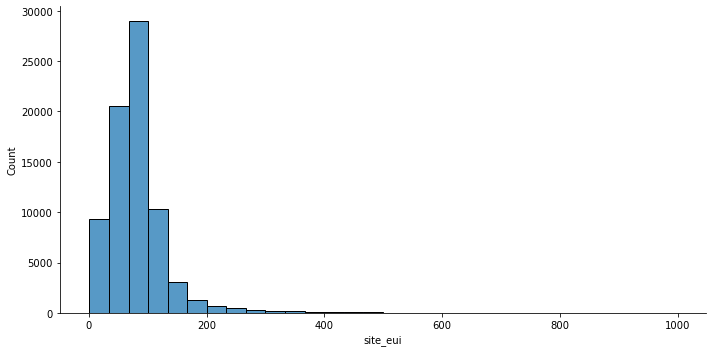

In [174]:
#Let's look at the distribution of our target variable.

sns.displot(
  data=data,
  x="site_eui",
  kind="hist",
  aspect=2,
  bins=30
)

We can see that we have a skewed data. Central tendency is where our general data lies and with machine learning algorithms we are trying to predict general behaviour, so knowing the correct measure of central tendency will help.

#### 2. Correlations between features and target variable

In [175]:
#Let's define a function to summarize some numeric variables and look for correlation between such column and the target.

def plot_feature(df , col):
    
    plt.figure(figsize = (6,4))
    
    mean = df.groupby(col)['site_eui'].mean()
    std = df.groupby(col)['site_eui'].std()
    mean.plot()
    plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, alpha = 0.1)
    plt.xticks(rotation = 45)
    plt.ylabel('Site EUI')    
    plt.show()
       

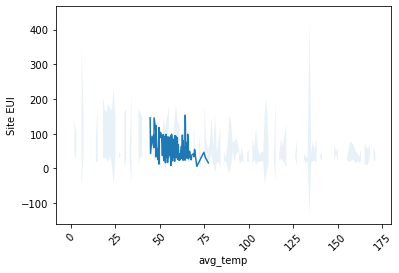

In [176]:
plot_feature(data , 'avg_temp')

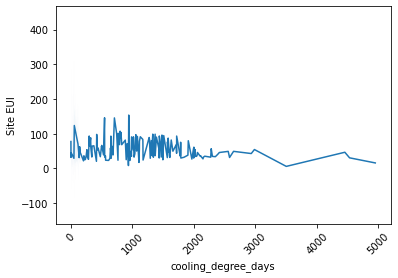

In [177]:
plot_feature(data , 'cooling_degree_days')

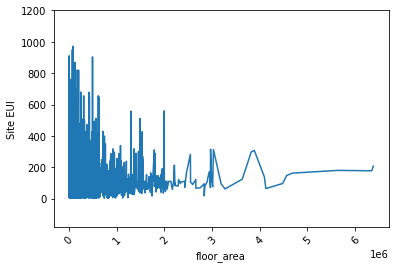

In [178]:
plot_feature(data , 'floor_area')

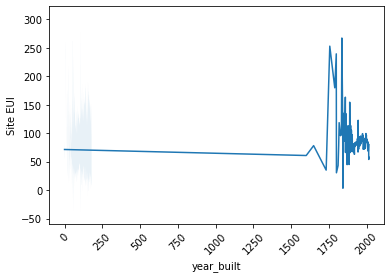

In [179]:
plot_feature(data, 'year_built')

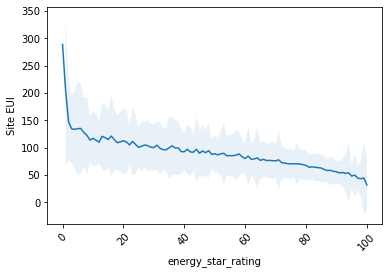

In [180]:
plot_feature(data , 'energy_star_rating')

We can see clearly that there is a negative linear relashionship between energy_star_rating and site_eui. The higher the site_eui, the lower the energy_star_rating.

#### 3. Outliers analysis

*Dealing with outliers in Site_eui*

Text(0, 0.5, 'Site Eui')

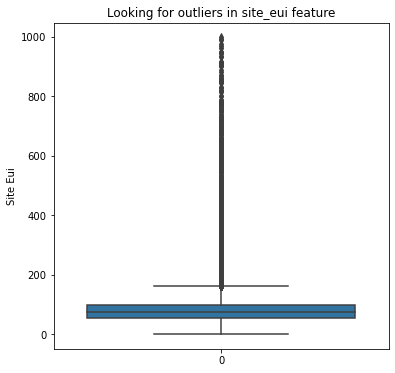

In [181]:
#First, let's evaluate our target variable.

plt.figure(figsize=(6,6))
sns.boxplot(data=data['site_eui'])
plt.title('Looking for outliers in site_eui feature')
plt.ylabel('Site Eui')

There are several outliers in the 'site_eui' variable so we need to do some research on it, as any changes can be determinant to our model. 
After looking at the Energy Star website we notice that our maximum value of 900 is inside the ranges of certain facility types. For example in hotels, the energy use intensity ranges from less than 100 to more than 800 kbtu/ft2 across all hotels. So our outliers here are a natural part of the population we are studying. As they do not seem erronous measurements, then we should not drop them or change them. We will keep the target data as it is.

*Dealing with outliers in year_built*

In [182]:
stat_yearbuilt= data['year_built'].describe()
print(stat_yearbuilt)

count    73920.000000
mean      1952.306764
std         37.053619
min          0.000000
25%       1927.000000
50%       1951.000000
75%       1977.000000
max       2015.000000
Name: year_built, dtype: float64


In [183]:
data = data.drop(data[data.year_built == 0].index)

#### 4. Dropping data that is not useful

There are 4 columns with > 50% of data missing, so we will proceed to drop them.

In [184]:
data = data.drop(['direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog'], axis=1)
test_data = test_data.drop(['direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog'], axis=1)

There are two more columns with null values, which are 'year_built' and 'energy star rating'. 

**Energy star rating:** As saw before in the distribution analysis, energy_star_rating is a very important feature to predict site_eui because it has a negative linear relation with 'site_eui' target variable, so we need to find a way to impute it correctly because it has a lot of null values.

**Year built:** As our missing values in year_built represent only a 2.4% we will drop those rows will null year_built feature.



In [185]:
#Dropping null values in year_built

data = data.dropna(subset = ['year_built'],axis=0)
test_data = test_data.dropna(subset = ['year_built'],axis=0)

In the case of Energy_star_rating we have a skewed data we can not consider the mean for imputation. Median would be a right central tendency measure in this case. But what about considering KNN imputation or iterative imputation? We will evaluate this and make the imputation later. 

#### 5. Encoding categorical values

Encoding building class, facility_type and state factor

In [186]:
# Import label encoder
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in the three categorical columns.
data['building_class']= label_encoder.fit_transform(data['building_class'])
data['facility_type']= label_encoder.fit_transform(data['facility_type'])
data['State_Factor']= label_encoder.fit_transform(data['State_Factor'])

#We should encode the same columns for our test data
test_data['building_class']= label_encoder.fit_transform(test_data['building_class'])
test_data['facility_type']= label_encoder.fit_transform(test_data['facility_type'])
test_data['State_Factor']= label_encoder.fit_transform(test_data['State_Factor'])

#### 6. Null value treatment

How will we treat our null values in Energy_star_rating ?

In [187]:
#It's time to separate our features from our target variable in our train set.

target = data['site_eui']

features = data.drop(['site_eui'], axis = 1)

In [188]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(imputation_order='ascending', random_state=42)

imputed_features = imputer.fit_transform(features)
imputed_test_features = imputer.fit_transform(test_data)

df_imputed = pd.DataFrame(imputed_features, columns=features.columns)
df_test_imputed = pd.DataFrame(imputed_test_features, columns=test_data.columns)

#### 7. Data Normalization

In [189]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(df_imputed)
scaled = scaler.fit_transform(df_imputed)
df_scaled = pd.DataFrame(scaled,columns = df_imputed.columns)

#We do the same for out test data

scaler.fit(df_test_imputed)
test_scaled = scaler.fit_transform(df_test_imputed)
df_test_scaled = pd.DataFrame(test_scaled,columns = df_test_imputed.columns)

In [190]:
df_scaled = df_scaled.drop('id',axis = 1).copy()

## Modeling

How will I know if my model is having a good result? I need to divide my training data into train and validation set, so that my model is tested on the validation set.

In [191]:
#Let's split our clean train data into training and validation sets

X_train, X_test, y_train, y_test = train_test_split(df_scaled, target, test_size=0.2, random_state=42)

**1st approach: Simple Linear regression between Energy Star Rating and Site_Eui**

In [192]:
X_train_lr = X_train[['energy_star_rating']]
X_test_lr = X_test[['energy_star_rating']]

In [193]:
#Fitting simple linear regression to the training set
lr = LinearRegression()
lr.fit(X_train_lr, y_train)

LinearRegression()

In [194]:
#to predict the test result
y_pred_lr = lr.predict(X_test_lr)

#to calculate the score
LinReg = round(lr.score(X_test_lr, y_test), 2)
  
#to calculate the rmse
rmse_lr = sqrt(mean_squared_error(y_test,y_pred_lr))
print('RMSE:', rmse_lr)

RMSE: 52.39242635470163


**2nd approach: Random Forest Regressor**

In [195]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [196]:
#to predict the test result
y_pred_rf = rf.predict(X_test)
  
#to calculate the rmse
rmse = sqrt(mean_squared_error(y_test,y_pred_rf))
print('RMSE:', rmse)

RMSE: 39.19814027549087


**3rd approach: Train the model with the best random forest features**

In [197]:
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(RandomForestRegressor())
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor())

In [198]:
selected_feat= df_scaled.columns[(sel.get_support())]
len(selected_feat)

6

In [199]:
print(selected_feat)

Index(['building_class', 'facility_type', 'floor_area', 'year_built',
       'energy_star_rating', 'ELEVATION'],
      dtype='object')


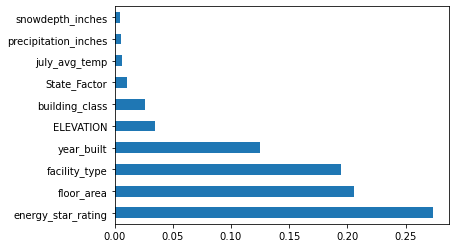

In [200]:
feat_importances = pd.Series(rf.feature_importances_, index=df_scaled.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [201]:
#Create A Data Subset With Only The Most Important Features

X_train_important = sel.transform(X_train)
X_test_important = sel.transform(X_test)

In [202]:
#Train A New Random Forest Regressor Using Only Most Important Features

rf1 = RandomForestRegressor()
rf1.fit(X_train_important, y_train)

RandomForestRegressor()

In [203]:
# Apply the new regressor to the validation data
y_pred_important = rf1.predict(X_test_important)

# View The root mean squareed error of our limited model
rmse_important = sqrt(mean_squared_error(y_test,y_pred_important))
print('RMSE:', rmse_important)

RMSE: 36.79594186060283


## Make Predictions

First, we need to convert our test data into the same format of our final data taht was used by the model. 
To do so, we would need to filter only the 6 most important features, as we did with the training data.

In [204]:
final_test_data = df_test_scaled[['building_class', 'facility_type', 'floor_area', 'year_built',
       'energy_star_rating', 'ELEVATION']]

In [205]:
#create predictions based on test data

predictions = rf1.predict(final_test_data)  

C:\Users\danie\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [206]:
print(len(predictions))

9613


In [207]:
ids = df_test_imputed[['id']]
predictions_df  = pd.DataFrame(predictions)
ids = ids.astype('int64')

In [208]:
submission_df = pd.concat([ids,predictions_df], axis= 1)

In [209]:
submission_df = submission_df.rename(columns={'0' : 'site_eui'})

In [210]:
submission_df.to_csv('submission.csv', index=False)

In [211]:
#Save the model 

import pickle

filename = "model.pkl"

pickle.dump(rf1, open(filename, 'wb'))